## Simulation1 structure

**Bandit algorithm** : LinUCB .. (other algorithms: epsilon greedy, thompson sampling ... etc)

Aim : Estimate the relative performance of an RL agent assuming that *a third of the sample does not accurately report their non-adherence barrier at baseline*

Bandits = Patients ( 60 total with different barrier to medication adherence)  
    - type1 = safety and efficacy of their medications
    - type2 = doubts about their disease severity
    - type3 = both concerns about their medications as well as problems remembering to take them
    Baseline adherence rate : 57%

Agent = Chooses action based on LinUCB  
    - Expected reward of action is linear to the state(context) of action
    - where weights are obtained by incremental ridge regression
$$\hat{w}_{a,t} = argmin_v\ \lambda||v||^2 + \sum_{t':a_{t'}=a}(\hat{r_{t'}} - v^Tx_{t',a})$$
$$a_t = argmax_{a\in{1,..,K}} \hat{w_a}^Tx_{t,a} + c_t\sqrt{x_{t,a}^T\Sigma_{a,t}x_{t,a}}$$


Ridge regression weight summation part is added for all the time points where action was a. ( Agent should be remembering action according to time)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [3]:
patients = np.vstack(
            (np.tile([1, 0, 0], (20,1)),
             np.tile([0, 1, 0], (20,1)),
             np.tile([1, 0, 1], (20,1))))

In [851]:
class MultiArmedBandit():
    """
    Multi-armed single Bandit
    Args
        k: number of arms
    """
    def __init__(self, k):
        self.k = k
        self.action_values = np.zeros(k)
        self.optimal = None
        
    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = None
    
    def pull(self, action):
        return 0, True  # returns reward and True if action is optimal.

    
class ContextualBandit(MultiArmedBandit):
    """
    Usually it is normal to have the agent keep the state of each bandit.
    But in some cases it is easier to have bandit keep their own state.
    Args
        k: number of arms
        d: dimension of state vector given action
    """
    def __init__(self, k, d):  # d: dimension of state
        super(ContextualBandit, self).__init__(k)
        self.d = d
        self.states = np.zeros((self.k, self.d))
    
    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = 0
        self.states = np.zeros((self.k, self.d))

In [856]:
class Patient(ContextualBandit):  # Patients have their context record...
    def __init__(self, k, d, patient_id, barriers):
        assert type(barriers) == np.ndarray
        
        super().__init__(k, d)
        self.memory = {action: np.array([]) for action in range(self.k)}
        self.patient_id = patient_id
        self.barriers = barriers  # possible examples = [1, 0, 0], [0, 1, 0], [1, 0, 1]
        self.reset()

    def __set_alpha(self, barriers):
#         return np.array([barrier*0.65
#                          if barrier == 1 else 1 for barrier in barriers])
        return np.array([barrier*np.random.normal(0.65, 0.15)
                         if barrier == 1 else 1 for barrier in barriers])
#         return np.array([barrier*max(min(np.random.normal(0.65, 0.3), 1), 0)
#                          if barrier == 1 else 1 for barrier in self.barriers])


    def __set_adherence(self, alphas):  # We can change this with logit function later.
        return(np.prod(alphas, axis=0))

    def __update_adherence(self, match):
#         self.alphas = np.array([barrier*max(min(np.random.normal(0.65, 0.3), 1), 0)
#                                 if barrier == 1 else 1 for barrier in self.barriers])
        self.alphas = self.__set_alpha(self.barriers)
        if self.barriers[match]:
#             beta = max(min(np.random.normal(loc=0.7, scale=0.3), 1), 0)
#             self.alphas[match] = np.minimum(self.alphas[match] + beta*(1.0 - self.alphas[match]), 1)
            beta = np.random.normal(loc=0.7, scale=0.3)
            self.alphas[match] = self.alphas[match] + beta*(1.0 - self.alphas[match])
        self.action_values = np.multiply(self.alphas, -1)
        self.adherence = np.prod(self.alphas, axis=0)
    
    def __update_state(self, action, iseffective):
        # Memory를 state의 dimension에 맞게 update 해야
        if self.memory[action].size:
            self.memory[action] = np.vstack((self.memory[action], np.array([int(iseffective)])))
        else:
            self.memory[action] = np.array([int(iseffective)])
        self.states[action] = sum(self.memory[action][-5:])  # FIXME
    
    def reset(self):
        self.alphas = self.__set_alpha(self.barriers)
        self.action_values = np.multiply(self.alphas, -1)
        self.adherence = self.__set_adherence(self.alphas)
        self.optimal = np.where((self.alphas < 1) & (self.barriers == 1))[0]
        self.states = np.zeros((self.k, self.d))
        self.memory = {action: np.array([]) for action in range(self.k)}

    
    def pull(self, action):
        self.__update_adherence(action)
        self.optimal = np.where((self.alphas < 1) & (self.barriers == 1))[0]
        # 어떻게 할 것인가.... 다 111되면 어떻게 처리 할 것인가 그래도 optimal한 선택인가 ? ... 시 뽤 
        if np.random.rand() < self.adherence:
            self.__update_state(action, True)
            return (1, action in self.optimal)
        else:
            self.__update_state(action, False)
            return (0, action in self.optimal)
    
    def __repr__(self):
        return("Patient {} with barriers {}".format(self.patient_id, self.barriers))

In [4]:
from example.sim3_bandit import Patient
import numpy as np

In [5]:
k = 4
d = 2

In [9]:
p = Patient(k, d, 1, np.array([1, 0, 0]))

In [10]:
p.optimal

array([0], dtype=int64)

In [31]:
p.adherence

0.89480100888370118

In [42]:
p.isLingering

True

In [36]:
p.fatigue_fct

0.95

In [44]:
p.optimal[0]

0

In [41]:
p.msg_sent

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [40]:
p.pull(1)

(1, False)

In [62]:
p.alphas

array([ 0.87757733,  1.        ,  1.        ])

In [63]:
p.adherence

0.87757733066675614

In [103]:
np.mean(np.maximum(np.minimum(np.random.normal(0.65, 0.3, 100000), 1), 0))

0.63294714685329501

In [38]:
b = []
for a in range(1000):
    p.pull(0)
    b.append(p.adherence)
np.mean(b)

0.87911457939878623

In [39]:
b = []
for a in range(1000):
    p.pull(1)
    b.append(p.adherence)
np.mean(b)

0.64603268041511441

In [41]:
1/3*0.88 + 2/3*0.64

0.72

In [40]:
b = []
for a in range(1000):
    p.pull(np.random.randint(3))
    b.append(p.adherence)
np.mean(b)

0.71363914897087866

In [43]:
p.pull(1)

(1, False)

In [44]:
p.alphas

array([1, 1, 1])

In [45]:
p.action_values

array([-1, -1, -1])

In [46]:
p.states

array([[ 5.],
       [ 3.],
       [ 4.]])

In [47]:
p.memory

{0: array([[1],
        [1],
        [1],
        ..., 
        [1],
        [1],
        [1]]), 1: array([[1],
        [1],
        [1],
        ..., 
        [0],
        [1],
        [1]]), 2: array([[0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],

# Bandit manager

In [742]:
class MultiBandits():
    def __init__(self):
        self.bandits = []
        self.bandit = None
        self.cursor = 0
        self.k = 0
        self.reset()
    
    def reset(self):
        self.bandits = []
        self.bandit = None
        self.cursor = 0

    def add_bandit(self, bandit):
        self.bandits.append(bandit)
        self.k = bandit.k

    def get_bandit(self):  
        # 여러 bandit들 중 어떤 순서로 고를 껀지, 순서대로 고를껀지 랜덤하게 고를껀지 정해야..
        # self.bandit = self.bandits[np.random.choice(list(self.bandits))]
        # 아니면 처음에 bandit을 shuffle 한 상태로 add 해주면 됨 ! 
        self.bandit = self.bandits[self.cursor]
        self.k = self.bandit.k
        self.cursor += 1
        if self.cursor == len(self.bandits):
            self.cursor = 0
    
    def pull(self, action):
        return self.bandit.pull(action)

### Add all the generated patient data into Contextual_bandit

In [49]:
m_bandits = MultiBandits()

In [50]:
for patient_id, barrier in enumerate(patients):
    patient = Patient(3, 1, barriers=barrier, patient_id=patient_id)
    m_bandits.add_bandit(patient)

In [702]:
m_bandits.get_bandit()

In [703]:
m_bandits.bandit

Patient 0 with barriers [1 0 0]

In [704]:
m_bandits.pull(0)

(1, True)

In [79]:
m_bandits.bandit.states

array([[ 1.],
       [ 0.],
       [ 0.]])

In [80]:
m_bandits.reset()

In [81]:
m_bandits.bandits

[]

# Policy

In [852]:
class Policy():
    """
    A policy decides an action to be choosen according to the policy
    """
    def choose(self):
        pass

class UCBPolicy(Policy):
    """
    UCB Policy chooses action which maximizes Upper Confidence Bound
    """
    def __init__(self, c=2):
        self.c = c
        
    def choose(self, agent):
        exploration = 2*np.log(agent.t+1) / agent.action_attempts
        exploration[np.isnan(exploration)] = 0
        exploration = np.power(exploration, 1/self.c)
        
        ucb = agent.value_estimates + exploration
        action = np.argmax(ucb)
        return action
        

class LinUCBPolicy(UCBPolicy):
    """
    LinUCB assumes expected reward is a linear combination of state(context)
    given an action.
    """
    def __init__(self, alpha, d):
        self.alpha = alpha
        self.d = d
    
    def choose(self, agent):
        ucb = np.array([])
        
        for action, memory in agent.memory.items():
            A_inv = np.linalg.inv(memory['A'])
            x_t = agent.states[action]
            exploration = self.alpha*np.sqrt(np.dot(np.dot(x_t.T, A_inv), x_t))
            ucb = np.append(ucb, agent.value_estimates[action]+ exploration)
            
        ucb += np.random.choice(len(ucb))*0.000001  # For tie values
        action = np.argmax(ucb)
 
#         print(est_mean_reward < exploration)
#         print("UCBs are : {}, t = {}".format(ucb, agent.t))
#         print("chosen actions : {}".format(action))

        return action

class RandomPolicy(Policy):
    
    def choose(self, agent):
        action = np.random.randint(agent.k)

## RL Agent 

Can be changed according to various simulation environments

In [853]:
class Agent():
    def __init__(self, k, policy, prior=0, gamma=None):
        self.policy = policy
        self.k = k
        self.prior = prior
        self.gamma = gamma
        self._value_estimates = prior*np.ones(self.k)  # Estimated Mean reward
        self.action_attempts = np.zeros(self.k)
        self.t = 0
        self.last_action = None
    
    def reset(self):
        """
        Resets the agent's memory to an initial state.
        """
        self._value_estimates[:] = self.prior*np.ones(self.k)
        self.action_attempts[:] = np.zeros(self.k)
        self.last_action = None
        self.t = 0
    
    def choose(self, random_period):
        if self.t < random_period:
            action = np.random.randint(self.k)
        else:
            action = self.policy.choose(self)
        self.last_action = action
        return action
    
    def observe(self, reward): # Updating value_estimates ! (calculating mean rewards)
        self.action_attempts[self.last_action] += 1
        
        if self.gamma is None:
            g = 1 / self.action_attempts[self.last_action]
        else:
            g= self.gamma
        q = self._value_estimates[self.last_action]
        
        self._value_estimates[self.last_action] += g*(reward - q)
        self.t += 1
    
    @property
    def value_estimates(self):
        return self._value_estimates

Agent -> 처음에 patient골라지면, state 받고, choose(self), observe(reward

In [854]:
class ContextualAgent(Agent):
    """
    ( for linUCB disjoint model)
    """
    def __init__(self, k, d, policy, prior=0, gamma=None):
        super(ContextualAgent, self).__init__(k, policy, prior, gamma)
        self.d = d
        self.memory = {action:{'A':np.identity(self.d), 'b':np.zeros((self.d, 1))} for action in range(self.k)}
        self.states = None
        self.reset()
    
    def reset(self):
        self._value_estimates[:] = self.prior*np.ones(self.k)
        self.action_attempts[:] = 0
        self.last_action = None
        self.t = 0
        self.memory = {action:{'A':np.identity(self.d), 'b':np.zeros((self.d, 1))} for action in range(self.k)}
        self.states = None
        
    def choose(self, random_period):
        return super().choose(random_period)
    
    ##################### FIXME
    ##### Agent가 random 하게 get_bandit을 하고, 거기서 나온 bandit의 state을 갖고 있는게 밪음.
    ### 그렇다면 Agent가 bandit manager가 가진 정보인 총 bandit 수, 그리고 해당 bandit의 state을 보유하고 있어야함.
    def get_state(self, bandit):
        self.states = bandit.states
        for action, memory in self.memory.items():
            A = memory['A']
            b = memory['b']
            A_inv = np.linalg.inv(A)
            theta_hat = np.dot(A_inv, b)
            x_t = self.states[action]
            self._value_estimates[action] = np.dot(x_t.T, theta_hat)
            # 사실은 순서가... agent 에서 value estimate을 이미 갖고 있는게.. 맞지 않을까 싶네요..ㅎ
            # 그렇게 합시다 ! 
            
    def observe(self, reward):
        self.action_attempts[self.last_action] += 1        
        self.memory[self.last_action]['A'] += np.outer(self.states[self.last_action],
                                                self.states[self.last_action])
        if self.memory[self.last_action]['b'].size:
            self.memory[self.last_action]['b'] += reward*self.states[self.last_action]        
        else:
            self.memory[self.last_action]['b'] = reward*self.states[self.last_action]

        self.t += 1

## Environment

In [4]:
# class Environment():
#     def __init__(self):
#         pass
    
#     def run(self, episode, trial):
#         pass
    
#     def

시작! 
#1. Bandit(Patient)를 정의한다 ! 
#2. Multibandit이므로, mbandit에다가 더해준다

#3. Policy를 고른다. (LinUCB)
#4. Agent를 정해준다. Contextualbandit !)

In [1]:
m_bandits = MultiBandits()
for patient_id, barrier in enumerate(patients):
        patient = Patient(3, 1, barriers=barrier, patient_id=patient_id)
        m_bandits.add_bandit(patient)


np.random.shuffle(m_bandits.bandits)
        

alpha = 0.1  # ??... 왜 영향을 안끼치지가 아니라 낮을 수록 빨리 수렴하네(exploitation)
d=1
linucb = LinUCBPolicy(alpha, d)
c_agent = ContextualAgent(m_bandits.k, d, linucb)

np.mean([bandit.adherence for bandit in m_bandits.bandits])

NameError: name 'MultiBandits' is not defined

#5. 각 patient당 1번식, state를 받아서, 총 100번의 episode를 돌려보자.

순서:
Patient가 정해지고, agent가 patient의 state을 받는다.  
jState을 통해 action이 정해지고, arm을 당긴다  
bandit이 반응을 하고, agent가 bandit의 reward를 observe한다.  
agent의 state memory가 update 된다.

([<matplotlib.axis.YTick at 0x27e84274080>,
 <a list of 5 Text yticklabel objects>)

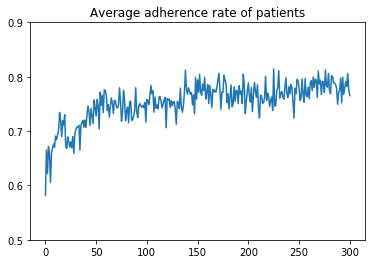

In [858]:
episodes = 300
trial = 1 

average_adh = []
average_adh.append(np.mean([bandit.adherence for bandit in m_bandits.bandits]))

for episode in range(episodes):

    for _ in range(len(m_bandits.bandits)):
        m_bandits.get_bandit()
        c_agent.get_state(m_bandits.bandit)
########RANDOM#######################
#         action = np.random.randint(c_agent.k)
#         c_agent.last_action = action
#####################################

########Tailored#####################
#         if _ % 3 == 0:
#             action = np.random.randint(c_agent.k)
#             c_agent.last_action = action
#         else:
#             action = np.random.choice(np.where(m_bandits.bandit.barriers==1)[0])
#             c_agent.last_action = action
####################################

#########RL############
        action = c_agent.choose(random_period=len(m_bandits.bandits)*10)
########################
#             print('True Optimal Choice :{}\n'.format(m_bandits.bandit.barriers))
        reward = m_bandits.pull(action)
        c_agent.observe(reward[0])

    average_adh.append(np.mean([bandit.adherence for bandit in m_bandits.bandits]))
#         print('Is this action {} optimal ? : {}'.format(action, reward[1]))
#         print('current bandit and alpha : {}, {} \n'.format(m_bandits.bandit, m_bandits.bandit.alphas))
plt.plot(average_adh)
plt.title("Average adherence rate of patients")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

In [839]:
np.mean(average_adh[-50:])

0.7628947468588515

# Tuning Alpha

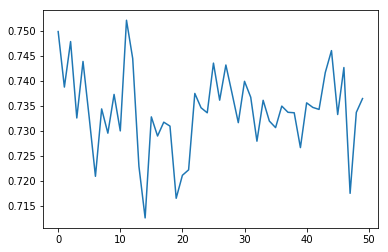

In [542]:
episodes = 300
trial = 1 



mean_adherence = []
for alpha in np.linspace(0, 25, num=50):
    m_bandits = MultiBandits()
    for patient_id, barrier in enumerate(patients):
            patient = Patient(3, 1, barriers=barrier, patient_id=patient_id)
            m_bandits.add_bandit(patient)

    d = 1
    linucb = LinUCBPolicy(alpha, d)
    c_agent = ContextualAgent(m_bandits.k, d, linucb)
    average_adh = []
    average_adh.append(np.mean([bandit.adherence for bandit in m_bandits.bandits]))

    for episode in range(episodes):

        for _ in range(len(m_bandits.bandits)):
            m_bandits.get_bandit()
            c_agent.get_state(m_bandits.bandit)
            action = c_agent.choose(random_period=len(m_bandits.bandits)*10)
#             print('True Optimal Choice :{}\n'.format(m_bandits.bandit.barriers))
            reward = m_bandits.pull(action)
            c_agent.observe(reward[0])

        average_adh.append(np.mean([bandit.adherence for bandit in m_bandits.bandits]))

    mean_adherence.append(np.mean(average_adh))

plt.plot(mean_adherence)
#         print('Is this action {} optimal ? : {}'.format(action, reward[1]))
#         print('current bandit and alpha : {}, {} \n'.format(m_bandits.bandit, m_bandits.bandit.alphas))
# plt.plot(average_adh)
# plt.title("Average adherence rate of patients")
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

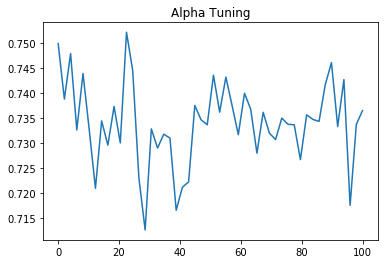

In [543]:
plt.plot(np.linspace(0, 25, 50), mean_adherence)
plt.title("Alpha Tuning")

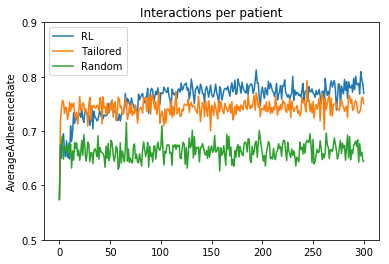

In [664]:
plt.plot(RL_avg)
plt.plot(Tailored_avg)
plt.plot(Random_avg)
plt.title("Interactions per patient")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel("AverageAdherenceRate")
plt.legend(("RL", "Tailored", "Random"))

In [509]:
Tailored_avg = average_adh

In [ ]:
plt.plot(Tailored_avg)
plt.title("Interactions per patient, Tailored")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel("AverageAdherenceRate")

In [463]:
Random_avg = average_adh

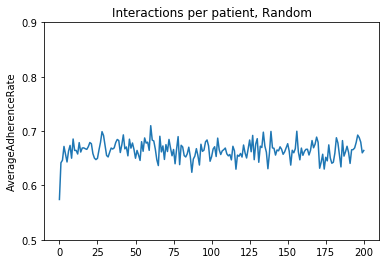

In [476]:
plt.plot(Random_avg)
plt.title("Interactions per patient, Random")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel("AverageAdherenceRate")

In [472]:
RL_avg = average_adh

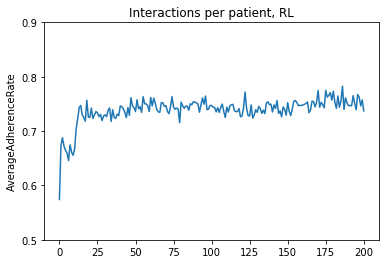

In [475]:
plt.plot(RL_avg)
plt.title("Interactions per patient, RL")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel("AverageAdherenceRate")

([<matplotlib.axis.YTick at 0x17300874668>,
 <a list of 5 Text yticklabel objects>)

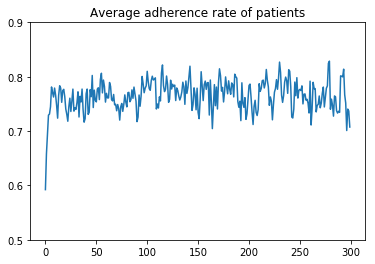

In [1114]:
plt.plot(average_adh)
plt.title("Average adherence rate of patients")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

In [512]:
import pandas as pd

In [665]:
df = pd.DataFrame(dict(RL=RL_avg, Random=Random_avg, Tailored=Tailored_avg))

In [666]:
df.to_csv("2017-06-24_Result2.csv")

In [15]:
import numpy as np

In [43]:
a = np.ndarray(shape=(3,1))

In [45]:
aa = np.hstack((a, np.ndarray(shape=(3,1))))

In [54]:
aa = np.hstack((aa, np.zeros(shape=(3,1))))

In [55]:
aa

array([[  1.12756537e+093,   1.12756537e+093,   0.00000000e+000],
       [  2.22525176e+088,   2.22525176e+088,   0.00000000e+000],
       [  1.98388552e-317,   1.98388552e-317,   0.00000000e+000]])

In [88]:
np.apply_along_axis(np.prod, 1, aa[:, -2:])

array([ 0.,  0.,  0.])

In [67]:
if np.where(aa == 2)[0].size:
    print('asdf')